In [ ]:
#All CEEW CODE 


Top 5 Wards by Number of Complaints:
      Ward_Name  occurrences
202     MUNDAKA         2126
258   LADOSARAI         1906
31     KAKRAULA         1512
105       DEOLI         1445
247  KISHANGARH         1274

Occurrences in each zone (All Complaints):
     index  occurrences
0        0           47
1        1           50
2        2           82
3        3           25
4        4           40
..     ...          ...
285    285           36
286    286          180
287    287           64
288    288          245
289    289            2

[290 rows x 2 columns]


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\415237865.py:98: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_union = delhi_gdf.geometry.unary_union



Map saved as delhi_all_complaints_map.jpg


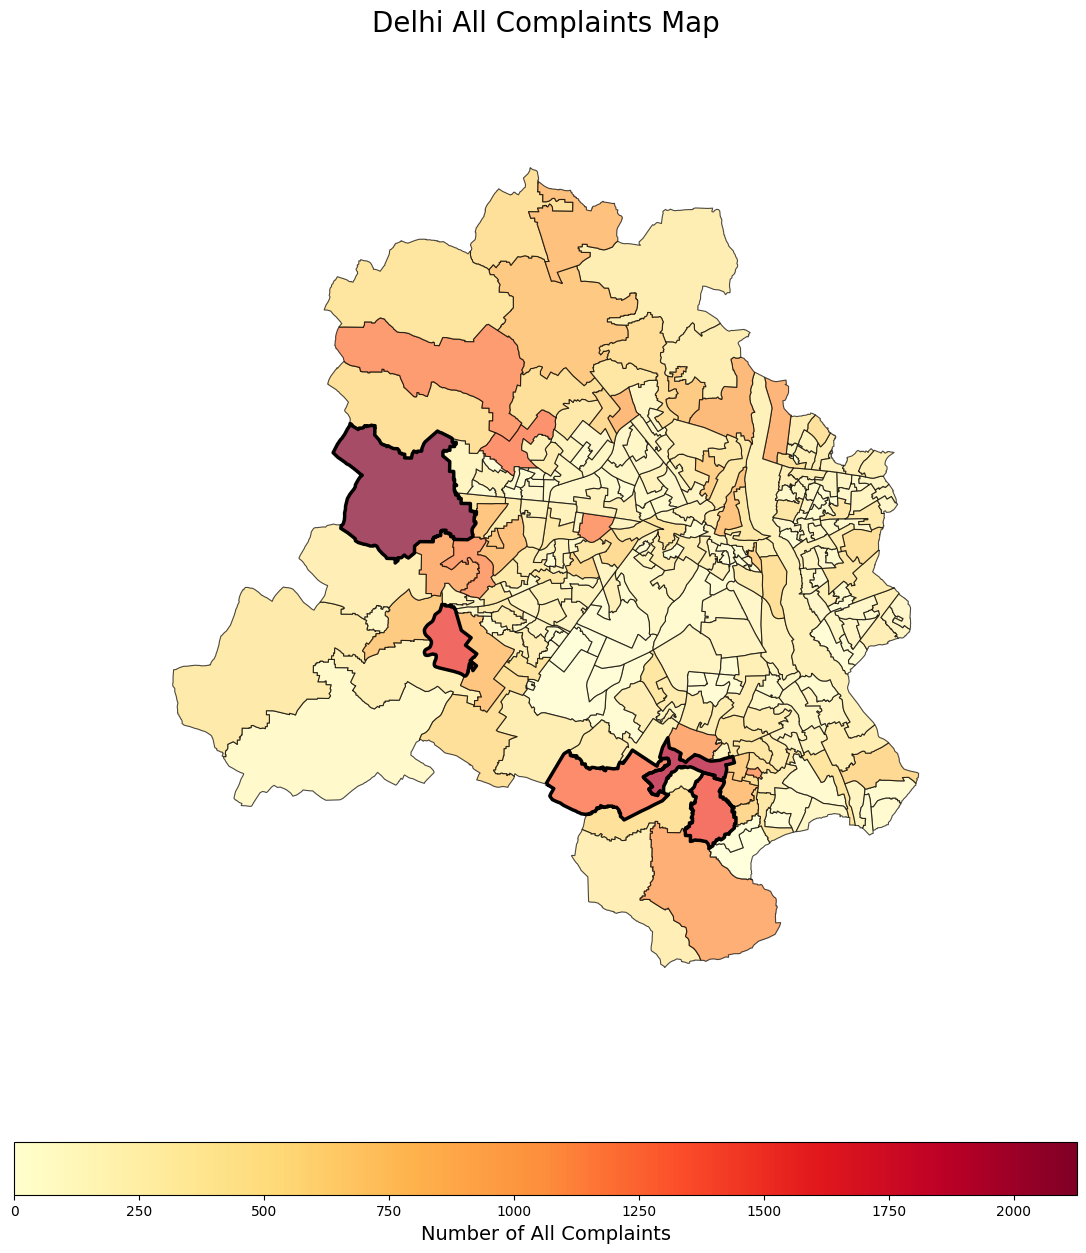

In [1]:
#Chloropleth map that shows complaint count of all the wards highlighting top 5 wards
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point, box
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

# Load the CSV file with a specified encoding
csv_path = r"C:\Users\wasee\Downloads\sorted_complaintsnew.csv"
complaints_df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# Split latitude and longitude into separate columns
complaints_df[['Latitude', 'Longitude']] = complaints_df['Latitude & Longitude'].str.split(',', expand=True)
complaints_df['Latitude'] = complaints_df['Latitude'].astype(float)
complaints_df['Longitude'] = complaints_df['Longitude'].astype(float)

# Use all complaints instead of filtering for pending ones
all_complaints_df = complaints_df

# Load the shapefile
shp_path = r'C:\Users\wasee\Downloads\Delhi_Wards.shp'
delhi_gdf = gpd.read_file(shp_path)

# Create GeoDataFrame for all complaints
geometry = [Point(xy) for xy in zip(all_complaints_df['Longitude'], all_complaints_df['Latitude'])]
all_complaints_gdf = gpd.GeoDataFrame(all_complaints_df, geometry=geometry)

# Set CRS for both GeoDataFrames if needed
if delhi_gdf.crs is None:
    delhi_gdf.set_crs(epsg=4326, inplace=True)
    
all_complaints_gdf.crs = delhi_gdf.crs

# Perform a spatial join to aggregate occurrences by region
joined_gdf = gpd.sjoin(all_complaints_gdf, delhi_gdf, how='left', predicate='within')

# Count occurrences in each region
region_counts = joined_gdf.groupby('index_right').size()

# Get ward name information if available in the shapefile
if 'name' in delhi_gdf.columns:
    ward_name_col = 'name'
elif 'NAME' in delhi_gdf.columns:
    ward_name_col = 'NAME'
elif 'Ward_Name' in delhi_gdf.columns:
    ward_name_col = 'Ward_Name'
elif 'WARD_NAME' in delhi_gdf.columns:
    ward_name_col = 'WARD_NAME'
else:
    ward_name_col = None
    print("No ward name column found, using index as identifier")

# Create a DataFrame with ward information and counts
if ward_name_col:
    ward_info = delhi_gdf[[ward_name_col]].copy()
    ward_info['occurrences'] = region_counts.reindex(delhi_gdf.index, fill_value=0)
    
    # Sort by occurrences to find top 5
    top_5_wards = ward_info.sort_values('occurrences', ascending=False).head(5)
    print("\nTop 5 Wards by Number of Complaints:")
    print(top_5_wards)
else:
    # Use index if no name column is available
    ward_info = pd.DataFrame(index=delhi_gdf.index)
    ward_info['occurrences'] = region_counts.reindex(delhi_gdf.index, fill_value=0)
    
    # Sort by occurrences to find top 5
    top_5_wards = ward_info.sort_values('occurrences', ascending=False).head(5)
    print("\nTop 5 Wards by Number of Complaints (using index):")
    print(top_5_wards)

# Merge the counts back to the GeoDataFrame
delhi_gdf['occurrences'] = region_counts.reindex(delhi_gdf.index, fill_value=0)

# Reset the index to ensure 'index' is available as a column
delhi_gdf = delhi_gdf.reset_index()

# Print occurrences for validation
print("\nOccurrences in each zone (All Complaints):")
print(delhi_gdf[['index', 'occurrences']])

# Create Folium map (this will still create the HTML version)
m = folium.Map(location=[28.7041, 77.1025], zoom_start=11)

# Create a larger background rectangle (much bigger than Delhi's bounds)
min_x, min_y, max_x, max_y = delhi_gdf.total_bounds
padding = 1
background_box = box(
    min_x - padding,
    min_y - padding,
    max_x + padding,
    max_y + padding
)

# Create the mask by subtracting Delhi's shape from the background
delhi_union = delhi_gdf.geometry.unary_union
mask = background_box.difference(delhi_union)

# Add the white background mask to the map
folium.GeoJson(
    mask.__geo_interface__,
    style_function=lambda x: {
        'fillColor': 'white',
        'color': 'white',
        'fillOpacity': 1,
        'weight': 0
    }
).add_to(m)

# Add the choropleth layer
folium.Choropleth(
    geo_data=delhi_gdf.__geo_interface__,
    data=delhi_gdf,
    columns=['index', 'occurrences'],
    key_on='feature.properties.index',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of All Occurrences'
).add_to(m)

# Save the map to an HTML file
m.save('delhi_all_complaints_map.html')

# Now create a static map with matplotlib for JPEG export
# Create a figure with white background
fig, ax = plt.subplots(figsize=(15, 15), facecolor='white')
ax.set_facecolor('white')

# Create a colormap similar to YlOrRd in Folium
colors_list = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
cmap = colors.LinearSegmentedColormap.from_list('YlOrRd', colors_list)

# Plot the choropleth
delhi_gdf.plot(
    column='occurrences',
    cmap=cmap,
    linewidth=0.8,
    edgecolor='black',
    alpha=0.7,
    ax=ax
)

# Remove axis
ax.set_axis_off()

# Get the current axis limits
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# Add padding to ensure the white background covers everything
padding_factor = 0.1
width = x_max - x_min
height = y_max - y_min
x_min -= width * padding_factor
x_max += width * padding_factor
y_min -= height * padding_factor
y_max += height * padding_factor

# Reset the axis limits with padding
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Add title
plt.title('Delhi All Complaints Map', fontsize=20)

# Create a custom legend
# Get the min and max values for the colorbar
vmin = delhi_gdf['occurrences'].min()
vmax = delhi_gdf['occurrences'].max()

# Create a colorbar separately
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # You need to set an array for the ScalarMappable
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Number of All Complaints', fontsize=14)

# Optional: Highlight the top 5 wards on the map
# This requires finding the IDs after reset_index
if len(top_5_wards) > 0:
    # Get original indices of top 5 wards
    top_indices = top_5_wards.index.tolist()
    
    # Find these in the reset index dataframe
    for idx in top_indices:
        # Find the matching row in delhi_gdf
        ward_row = delhi_gdf[delhi_gdf['index'] == idx]
        if not ward_row.empty:
            # Add a thicker outline to highlight this ward
            ward_row.boundary.plot(ax=ax, color='black', linewidth=2.5)

# Save as JPEG with tight layout and white background
plt.savefig('delhi_all_complaints_map.jpg', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white', 
            edgecolor='none')

print("\nMap saved as delhi_all_complaints_map.jpg")

# Show the map
plt.show()


Top 5 Wards by Number of Pending Complaints:
               Ward_Name  occurrences
202              MUNDAKA          982
176    QUAMMRUDDIN NAGAR          465
120         PUNJABI BAGH          423
283              NILOTHI          311
165  PASCHIM VIHAR SOUTH          308

Occurrences in each zone (Pending Complaints):
     index  occurrences
0        0            4
1        1            4
2        2           18
3        3            1
4        4           17
..     ...          ...
285    285            8
286    286           23
287    287            3
288    288           34
289    289            0

[290 rows x 2 columns]


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\3136690926.py:99: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_union = delhi_gdf.geometry.unary_union



Map saved as delhi_pending_complaints_map.jpg


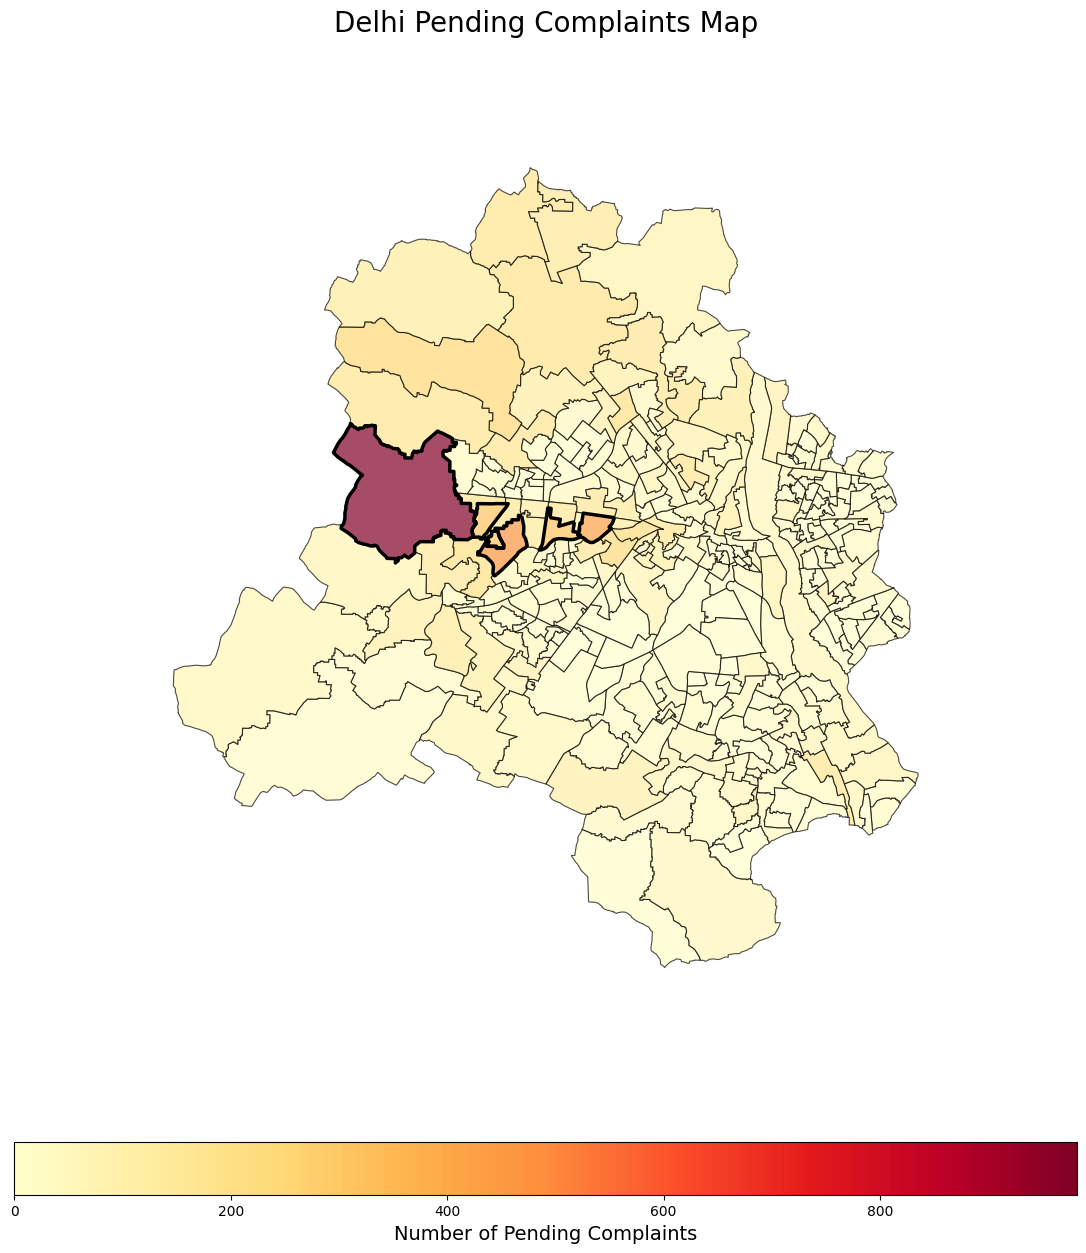

In [2]:
#Chloropleth map that shows pending complaint count of all the wards highlighting top 5 wards
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point, box
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

# Load the CSV file with a specified encoding
csv_path = r"C:\Users\wasee\Downloads\sorted_complaintsnew.csv"
complaints_df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# Split latitude and longitude into separate columns
complaints_df[['Latitude', 'Longitude']] = complaints_df['Latitude & Longitude'].str.split(',', expand=True)
complaints_df['Latitude'] = complaints_df['Latitude'].astype(float)
complaints_df['Longitude'] = complaints_df['Longitude'].astype(float)

# Filter for pending complaints
pending_complaints_df = complaints_df[complaints_df['Status'] == 'Pending']

# Load the shapefile
shp_path = r'C:\Users\wasee\Downloads\Delhi_Wards.shp'
delhi_gdf = gpd.read_file(shp_path)

# Create GeoDataFrame for pending complaints
geometry = [Point(xy) for xy in zip(pending_complaints_df['Longitude'], pending_complaints_df['Latitude'])]
pending_complaints_gdf = gpd.GeoDataFrame(pending_complaints_df, geometry=geometry)

# Set CRS for both GeoDataFrames if needed
if delhi_gdf.crs is None:
    delhi_gdf.set_crs(epsg=4326, inplace=True)
    
pending_complaints_gdf.crs = delhi_gdf.crs

# Perform a spatial join to aggregate occurrences by region
joined_gdf = gpd.sjoin(pending_complaints_gdf, delhi_gdf, how='left', predicate='within')

# Count occurrences in each region
region_counts = joined_gdf.groupby('index_right').size()

# Get ward name information if available in the shapefile
if 'name' in delhi_gdf.columns:
    ward_name_col = 'name'
elif 'NAME' in delhi_gdf.columns:
    ward_name_col = 'NAME'
elif 'Ward_Name' in delhi_gdf.columns:
    ward_name_col = 'Ward_Name'
elif 'WARD_NAME' in delhi_gdf.columns:
    ward_name_col = 'WARD_NAME'
else:
    ward_name_col = None
    print("No ward name column found, using index as identifier")

# Create a DataFrame with ward information and counts
if ward_name_col:
    ward_info = delhi_gdf[[ward_name_col]].copy()
    ward_info['occurrences'] = region_counts.reindex(delhi_gdf.index, fill_value=0)
    
    # Sort by occurrences to find top 5
    top_5_wards = ward_info.sort_values('occurrences', ascending=False).head(5)
    print("\nTop 5 Wards by Number of Pending Complaints:")
    print(top_5_wards)
else:
    # Use index if no name column is available
    ward_info = pd.DataFrame(index=delhi_gdf.index)
    ward_info['occurrences'] = region_counts.reindex(delhi_gdf.index, fill_value=0)
    
    # Sort by occurrences to find top 5
    top_5_wards = ward_info.sort_values('occurrences', ascending=False).head(5)
    print("\nTop 5 Wards by Number of Pending Complaints (using index):")
    print(top_5_wards)

# Merge the counts back to the GeoDataFrame
delhi_gdf['occurrences'] = region_counts.reindex(delhi_gdf.index, fill_value=0)

# Reset the index to ensure 'index' is available as a column
delhi_gdf = delhi_gdf.reset_index()

# Print occurrences for validation
print("\nOccurrences in each zone (Pending Complaints):")
print(delhi_gdf[['index', 'occurrences']])

# Create Folium map
m = folium.Map(location=[28.7041, 77.1025], zoom_start=11)

# Create a larger background rectangle (much bigger than Delhi's bounds)
min_x, min_y, max_x, max_y = delhi_gdf.total_bounds
padding = 1
background_box = box(
    min_x - padding,
    min_y - padding,
    max_x + padding,
    max_y + padding
)

# Create the mask by subtracting Delhi's shape from the background
delhi_union = delhi_gdf.geometry.unary_union
mask = background_box.difference(delhi_union)

# Add the white background mask to the map
folium.GeoJson(
    mask.__geo_interface__,
    style_function=lambda x: {
        'fillColor': 'white',
        'color': 'white',
        'fillOpacity': 1,
        'weight': 0
    }
).add_to(m)

# Add the choropleth layer
folium.Choropleth(
    geo_data=delhi_gdf.__geo_interface__,
    data=delhi_gdf,
    columns=['index', 'occurrences'],
    key_on='feature.properties.index',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Pending Complaints'
).add_to(m)

# Save the map to an HTML file
m.save('delhi_pending_complaints_map.html')

# Now create a static map with matplotlib for JPEG export
# Create a figure with white background
fig, ax = plt.subplots(figsize=(15, 15), facecolor='white')
ax.set_facecolor('white')

# Create a colormap similar to YlOrRd in Folium
colors_list = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
cmap = colors.LinearSegmentedColormap.from_list('YlOrRd', colors_list)

# Plot the choropleth
delhi_gdf.plot(
    column='occurrences',
    cmap=cmap,
    linewidth=0.8,
    edgecolor='black',
    alpha=0.7,
    ax=ax
)

# Remove axis
ax.set_axis_off()

# Get the current axis limits
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# Add padding to ensure the white background covers everything
padding_factor = 0.1
width = x_max - x_min
height = y_max - y_min
x_min -= width * padding_factor
x_max += width * padding_factor
y_min -= height * padding_factor
y_max += height * padding_factor

# Reset the axis limits with padding
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Add title
plt.title('Delhi Pending Complaints Map', fontsize=20)

# Create a custom legend
# Get the min and max values for the colorbar
vmin = delhi_gdf['occurrences'].min()
vmax = delhi_gdf['occurrences'].max()

# Create a colorbar separately
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # You need to set an array for the ScalarMappable
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Number of Pending Complaints', fontsize=14)

# Optional: Highlight the top 5 wards on the map
if len(top_5_wards) > 0:
    # Get original indices of top 5 wards
    top_indices = top_5_wards.index.tolist()
    
    # Find these in the reset index dataframe
    for idx in top_indices:
        # Find the matching row in delhi_gdf
        ward_row = delhi_gdf[delhi_gdf['index'] == idx]
        if not ward_row.empty:
            # Add a thicker outline to highlight this ward
            ward_row.boundary.plot(ax=ax, color='black', linewidth=2.5)

# Save as JPEG with tight layout and white background
plt.savefig('delhi_pending_complaints_map.jpg', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white', 
            edgecolor='none')

print("\nMap saved as delhi_pending_complaints_map.jpg")

# Show the map
plt.show()

In [3]:
#Code to get chloropleth of pending cases for diffrent offences  
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point, Polygon
import os
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster
from branca.element import Template, MacroElement
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
import numpy as np

# Load the CSV file with a specified encoding
csv_path = r"C:\Users\wasee\Downloads\sorted_complaintsnew.csv"
complaints_df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# Split latitude and longitude into separate columns
complaints_df[['Latitude', 'Longitude']] = complaints_df['Latitude & Longitude'].str.split(',', expand=True)
complaints_df['Latitude'] = complaints_df['Latitude'].astype(float)
complaints_df['Longitude'] = complaints_df['Longitude'].astype(float)

# Load the shapefile
shp_path = r'C:\Users\wasee\Downloads\Delhi_Wards.shp'
delhi_gdf = gpd.read_file(shp_path)

# Create output directory if it doesn't exist
output_dir = r'C:\Users\wasee\OneDrive\Desktop\ceew project\pending'
os.makedirs(output_dir, exist_ok=True)

# Get list of all unique offenses
offenses = complaints_df['Offences'].unique()

# Create a dictionary to store all ward counts for the master CSV
master_ward_counts = {}

# Process each offense
for offense in offenses:
    # Filter complaints for the specific offense and status
    status_filter = "Pending"
    filtered_complaints_df = complaints_df[(complaints_df['Offences'] == offense) & 
                                          (complaints_df['Status'] == status_filter)]
    
    # Skip if no records found for this offense
    if filtered_complaints_df.empty:
        print(f"No pending complaints found for offense: {offense}")
        continue
    
    # Create GeoDataFrame for filtered complaints
    geometry = [Point(xy) for xy in zip(filtered_complaints_df['Longitude'], filtered_complaints_df['Latitude'])]
    filtered_complaints_gdf = gpd.GeoDataFrame(filtered_complaints_df, geometry=geometry)
    
    # Ensure both GeoDataFrames use the same coordinate reference system (CRS)
    filtered_complaints_gdf.crs = delhi_gdf.crs
    
    # Perform a spatial join to aggregate occurrences by region
    joined_gdf = gpd.sjoin(filtered_complaints_gdf, delhi_gdf, how='left', predicate='within')
    
    # Count occurrences in each region
    region_counts = joined_gdf.groupby('index_right').size()
    
    # Create a DataFrame for ward-level counts for this offense
    ward_counts_df = pd.DataFrame({
        'Ward_ID': region_counts.index,
        'Ward_Name': [delhi_gdf.loc[idx, 'Ward_Name'] if idx in delhi_gdf.index else 'Unknown' for idx in region_counts.index],
        'Count': region_counts.values,
        'Offense': offense
    })
    
    # Create a safe filename from the offense
    safe_filename = "".join([c if c.isalnum() else "_" for c in offense])
    
    # Save individual CSV for this offense with counts for all wards
    ward_counts_file = os.path.join(output_dir, f'ward_counts_{safe_filename}.csv')
    ward_counts_df.to_csv(ward_counts_file, index=False)
    print(f"Saved ward counts for {offense} to {ward_counts_file}")
    
    # Update the master counts dictionary
    for idx, row in ward_counts_df.iterrows():
        ward_id = row['Ward_ID']
        ward_name = row['Ward_Name']
        
        if ward_id not in master_ward_counts:
            master_ward_counts[ward_id] = {'Ward_ID': ward_id, 'Ward_Name': ward_name}
        
        # Add this offense's count to the master dictionary
        master_ward_counts[ward_id][offense] = row['Count']
    
    # Merge the counts back to the GeoDataFrame
    delhi_gdf_with_counts = delhi_gdf.copy()
    delhi_gdf_with_counts['occurrences'] = region_counts.reindex(delhi_gdf.index, fill_value=0)
    
    # Reset the index to ensure 'index' is available as a column
    delhi_gdf_with_counts = delhi_gdf_with_counts.reset_index()
    
    # Prepare the GeoJSON data with updated properties
    geojson_data = delhi_gdf_with_counts.__geo_interface__
    
    # Update occurrences in each zone within the GeoJSON data
    for feature in geojson_data['features']:
        zone_id = feature['id']
        if zone_id in region_counts.index:
            feature['properties']['occurrences'] = int(region_counts.loc[zone_id])
        else:
            feature['properties']['occurrences'] = 0
    
    # Extract and save the top 5 wards with the highest occurrences
    top_5_wards = delhi_gdf_with_counts.nlargest(5, 'occurrences')[['Ward_Name', 'occurrences']]
    
    # Save the top 5 table as a CSV
    top_5_wards.to_csv(os.path.join(output_dir, f'top5_wards_{safe_filename}.csv'), index=False)
    
    # Also save as an HTML table for better visualization
    html_table = top_5_wards.to_html(index=False)
    with open(os.path.join(output_dir, f'top5_wards_{safe_filename}.html'), 'w') as f:
        f.write(f"<h2>Top 5 Wards for {offense} (Pending)</h2>\n")
        f.write(html_table)
    
    # Create a folium map centered around Delhi
    m = folium.Map(location=[28.7041, 77.1025], zoom_start=11)
    
    # Add the choropleth layer
    choropleth = folium.Choropleth(
        geo_data=geojson_data,
        data=delhi_gdf_with_counts,
        columns=['index', 'occurrences'],
        key_on='feature.properties.index',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f'Number of Pending Occurrences: {offense}'
    ).add_to(m)
    
    # Define the bounding box for the shapefile area
    bounds = delhi_gdf.total_bounds  # [minx, miny, maxx, maxy]
    
    # Create a large white polygon covering the entire map area
    map_bounds = Polygon([
        [bounds[0] - 1, bounds[1] - 1],
        [bounds[0] - 1, bounds[3] + 1],
        [bounds[2] + 1, bounds[3] + 1],
        [bounds[2] + 1, bounds[1] - 1]
    ])
    
    # Subtract the shapefile area to create the mask
    mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)
    
    # Add the mask to the map as a white overlay
    for geom in mask:
        folium.GeoJson(
            geom.__geo_interface__,
            style_function=lambda x: {
                'fillColor': 'white',
                'color': 'white',
                'fillOpacity': 1,
                'weight': 0
            }
        ).add_to(m)
    
    # Add tooltip to show ward name and count when hovering
    folium.GeoJson(
        geojson_data,
        style_function=lambda x: {'fillOpacity': 0, 'color': 'transparent'},
        tooltip=folium.GeoJsonTooltip(
            fields=['Ward_Name', 'occurrences'],
            aliases=['Ward Name:', 'Pending Cases:'],
            style=("background-color: white; color: #333; font-family: arial; font-size: 12px; padding: 10px;")
        )
    ).add_to(m)
    
    # Create a feature group for the markers
    marker_group = folium.FeatureGroup(name="Pending Cases")
    
    # Add markers for each complaint location
    for idx, row in filtered_complaints_df.iterrows():
        # Create a pop-up with relevant information
        popup_text = f"""
        <strong>Offense:</strong> {row['Offences']}<br>
        <strong>Zone:</strong> {row.get('Zone', 'Unknown')}<br>
        <strong>Status:</strong> {row['Status']}<br>
        """
        
        # Add a small circle marker instead of a standard marker for better performance
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=0.52,  # Very small radius
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=f"Case ID: {row.get('Complaint_ID', idx)}"
        ).add_to(marker_group)
    
    # Add the marker group to the map
    marker_group.add_to(m)
    
    # Add layer control to toggle between markers and choropleth
    folium.LayerControl().add_to(m)
    
    # Save the map to an HTML file
    map_file = os.path.join(output_dir, f'delhi_Pending_{safe_filename}.html')
    m.save(map_file)
    
    # Now modify the HTML file to center the legend
    with open(map_file, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Modify the legend CSS to position it in the center
    # Find the .legend CSS block and modify it
    legend_css_original = """
            .legend {
                line-height: 18px;
                color: #555;
            }
            .legend i {
                width: 18px;
                height: 18px;
                float: left;
                margin-right: 8px;
                opacity: 0.7;
            }
    """
    
    legend_css_centered = """
            .legend {
                line-height: 18px;
                color: #555;
                position: absolute;
                z-index: 1000;
                left: 50%;
                transform: translateX(-50%);
                bottom: 20px;
                background-color: white;
                padding: 10px;
                border-radius: 5px;
                box-shadow: 0 0 15px rgba(0,0,0,0.2);
            }
            .legend i {
                width: 18px;
                height: 18px;
                float: left;
                margin-right: 8px;
                opacity: 0.7;
            }
    """
    
    # Replace the original legend CSS with our centered version
    html_content = html_content.replace(legend_css_original, legend_css_centered)
    
    # Write the modified HTML back to the file
    with open(map_file, 'w', encoding='utf-8') as file:
        file.write(html_content)
    
    print(f"Processed: {offense} - Map with markers and centered legend saved")
    # Create a matplotlib figure for static map export
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Create a custom colormap similar to 'YlOrRd'
    colors = ['#ffffb2', '#fed976', '#feb24c', '#fd8d3c', '#f03b20', '#bd0026']
    cmap = LinearSegmentedColormap.from_list('custom_YlOrRd', colors)
    
    # Plot the choropleth map
    delhi_gdf_with_counts.plot(
        column='occurrences',
        ax=ax,
        cmap=cmap,
        edgecolor='#666666',
        linewidth=0.5,
        legend=True,
        legend_kwds={
            'label': f'Number of Pending Occurrences: {offense}',
            'orientation': 'horizontal',
            'shrink': 0.8,
            'pad': 0.01,
            'aspect': 25
        }
    )
    
    # Add basemap for context (optional)
    try:
        ctx.add_basemap(ax, crs=delhi_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    except Exception as e:
        print(f"Basemap couldn't be added - continuing without it: {e}")
    
    # Filter points to only include those within Delhi boundaries
    delhi_boundary = delhi_gdf.unary_union
    points_within_delhi = filtered_complaints_gdf[filtered_complaints_gdf.intersects(delhi_boundary)]
    print(f"Filtered out {len(filtered_complaints_gdf) - len(points_within_delhi)} points outside Delhi boundary")
    
    # Plot markers for each complaint location that is within Delhi boundaries
    if not points_within_delhi.empty:
        points_within_delhi.plot(
            ax=ax,
            color='blue',
            markersize=5,
            alpha=0.7,
            zorder=5  # Make sure points appear on top
        )
        
        # Add a legend for the markers
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                   markersize=8, label='Pending Complaints', alpha=0.7)
        ]
        ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
                  facecolor='white', edgecolor='gray')
    else:
        print(f"No points within Delhi boundary for {offense}")
    
    # Set the map extent to exactly match the Delhi boundaries
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    
    # Improve the appearance
    ax.set_title(f'Delhi Wards - Pending {offense} Cases', fontsize=16)
    ax.set_axis_off()  # Remove axis
    plt.tight_layout()
    
    # Save as JPEG
    jpeg_file = os.path.join(output_dir, f'delhi_Pending_{safe_filename}.jpg')
    plt.savefig(jpeg_file, format='jpeg', dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to free memory
    
    print(f"Static JPEG map with filtered markers saved for {offense}")

# Create and save the master CSV with all offenses for all wards
# First, ensure all wards from the shapefile are included in the master counts
for idx, row in delhi_gdf.iterrows():
    ward_id = idx
    ward_name = row['Ward_Name']
    
    if ward_id not in master_ward_counts:
        master_ward_counts[ward_id] = {'Ward_ID': ward_id, 'Ward_Name': ward_name}

# Convert master dictionary to DataFrame
master_df = pd.DataFrame.from_dict(master_ward_counts.values())

# Fill NaN values with zeros (wards with no complaints for a particular offense)
master_df = master_df.fillna(0)

# Calculate total pending complaints across all offense types
master_df['Total_Pending'] = master_df.drop(['Ward_ID', 'Ward_Name'], axis=1).sum(axis=1)

# Sort by total pending complaints
master_df = master_df.sort_values('Total_Pending', ascending=False)

# Save the master CSV
master_csv_path = os.path.join(output_dir, 'master_ward_pending_complaintsnewest.csv')

master_df.to_csv(master_csv_path, index=False)
print(f"Master CSV with all offense counts by ward saved to {master_csv_path}")

print("All offense maps, tables, and CSV files have been generated successfully!")

Saved ward counts for Air Pollution due to industries to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Air_Pollution_due_to_industries.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Air Pollution due to industries - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 1 points outside Delhi boundary
Static JPEG map with filtered markers saved for Air Pollution due to industries
Saved ward counts for Illegal dumping of Garbage on road sides/ vacant land to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Illegal_dumping_of_Garbage_on_road_sides__vacant_land.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Illegal dumping of Garbage on road sides/ vacant land - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 7 points outside Delhi boundary
Static JPEG map with filtered markers saved for Illegal dumping of Garbage on road sides/ vacant land
Saved ward counts for Dumping of Construction & Demolition Waste to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Dumping_of_Construction___Demolition_Waste.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Dumping of Construction & Demolition Waste - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 1 points outside Delhi boundary
Static JPEG map with filtered markers saved for Dumping of Construction & Demolition Waste
Saved ward counts for Burning of Biomass/garden waste to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Burning_of_Biomass_garden_waste.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Burning of Biomass/garden waste - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 0 points outside Delhi boundary
Static JPEG map with filtered markers saved for Burning of Biomass/garden waste
Saved ward counts for Burning of garbage/plastic waste to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Burning_of_garbage_plastic_waste.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Burning of garbage/plastic waste - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 2 points outside Delhi boundary
Static JPEG map with filtered markers saved for Burning of garbage/plastic waste
Saved ward counts for Dust Pollution due to Construction/ Demolition activity to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Dust_Pollution_due_to_Construction__Demolition_activity.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Dust Pollution due to Construction/ Demolition activity - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 4 points outside Delhi boundary
Static JPEG map with filtered markers saved for Dust Pollution due to Construction/ Demolition activity
Saved ward counts for Air pollution from the sources other than Industry to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Air_pollution_from_the_sources_other_than_Industry.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Air pollution from the sources other than Industry - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 3 points outside Delhi boundary
Static JPEG map with filtered markers saved for Air pollution from the sources other than Industry
Saved ward counts for Potholes on Roads to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Potholes_on_Roads.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Potholes on Roads - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 24 points outside Delhi boundary
Static JPEG map with filtered markers saved for Potholes on Roads
Saved ward counts for Road Dust to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Road_Dust.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Road Dust - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 3 points outside Delhi boundary
Static JPEG map with filtered markers saved for Road Dust
Saved ward counts for Noise pollution from the sources other than Industry to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Noise_pollution_from_the_sources_other_than_Industry.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Noise pollution from the sources other than Industry - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 0 points outside Delhi boundary
Static JPEG map with filtered markers saved for Noise pollution from the sources other than Industry
Saved ward counts for Visible smoke from vehicle exhaust to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Visible_smoke_from_vehicle_exhaust.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Visible smoke from vehicle exhaust - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 0 points outside Delhi boundary
Static JPEG map with filtered markers saved for Visible smoke from vehicle exhaust
Saved ward counts for Sale and Storage of banned SUP items to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Sale_and_Storage_of_banned_SUP_items.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Sale and Storage of banned SUP items - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 0 points outside Delhi boundary
Static JPEG map with filtered markers saved for Sale and Storage of banned SUP items
Saved ward counts for Mfg. of banned SUP items in non Industrial Area to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Mfg__of_banned_SUP_items_in_non_Industrial_Area.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Mfg. of banned SUP items in non Industrial Area - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 0 points outside Delhi boundary
Static JPEG map with filtered markers saved for Mfg. of banned SUP items in non Industrial Area
Saved ward counts for Mfg. of banned SUP items in Industrial Area to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Mfg__of_banned_SUP_items_in_Industrial_Area.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Mfg. of banned SUP items in Industrial Area - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 0 points outside Delhi boundary
Static JPEG map with filtered markers saved for Mfg. of banned SUP items in Industrial Area
Saved ward counts for Obstruction of pavements causing vehicular congestion to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Obstruction_of_pavements_causing_vehicular_congestion.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Obstruction of pavements causing vehicular congestion - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 0 points outside Delhi boundary
Static JPEG map with filtered markers saved for Obstruction of pavements causing vehicular congestion
Saved ward counts for Old vehicles which have completed registered life [End of Life Vehicles] to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Old_vehicles_which_have_completed_registered_life__End_of_Life_Vehicles_.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Old vehicles which have completed registered life [End of Life Vehicles] - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 0 points outside Delhi boundary
Static JPEG map with filtered markers saved for Old vehicles which have completed registered life [End of Life Vehicles]
Saved ward counts for Violation of Graded Response Action Plan(GRAP) of CAQM to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\ward_counts_Violation_of_Graded_Response_Action_Plan_GRAP__of_CAQM.csv


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:145: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = gpd.GeoSeries(map_bounds).difference(delhi_gdf.unary_union)


Processed: Violation of Graded Response Action Plan(GRAP) of CAQM - Map with markers and centered legend saved
Basemap couldn't be added - continuing without it: 'NoneType' object has no attribute 'to_string'


C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\1863903959.py:286: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  delhi_boundary = delhi_gdf.unary_union


Filtered out 1 points outside Delhi boundary
Static JPEG map with filtered markers saved for Violation of Graded Response Action Plan(GRAP) of CAQM
Master CSV with all offense counts by ward saved to C:\Users\wasee\OneDrive\Desktop\ceew project\pending\master_ward_pending_complaintsnewest.csv
All offense maps, tables, and CSV files have been generated successfully!


In [4]:
#Code for GVP identification
import pandas as pd
import folium
import geopandas as gpd
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from tabulate import tabulate

# Load the CSV file with a specified encoding
csv_path = r"C:\Users\wasee\Downloads\sorted_complaintsnew.csv"
complaints_df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# Remove rows 2 to 57556
complaints_df = complaints_df.drop(complaints_df.index[1:57556])

# Split latitude and longitude into separate columns
complaints_df[['Latitude', 'Longitude']] = complaints_df['Latitude & Longitude'].str.split(',', expand=True)
complaints_df['Latitude'] = complaints_df['Latitude'].astype(float)
complaints_df['Longitude'] = complaints_df['Longitude'].astype(float)

# Filter for "Dumping of Construction & Demolition Waste" offences
illegal_dumping_df = complaints_df[complaints_df['Offences'] == 'Illegal dumping of Garbage on road sides/ vacant land'].copy()

# Convert coordinates to radians for haversine calculation
illegal_dumping_df['Latitude_rad'] = np.radians(illegal_dumping_df['Latitude'])
illegal_dumping_df['Longitude_rad'] = np.radians(illegal_dumping_df['Longitude'])

# Apply DBSCAN with a 5-meter radius (approximately 0.000045 radians) and minimum samples of 1
coords = illegal_dumping_df[['Latitude_rad', 'Longitude_rad']].values
db = DBSCAN(eps=0.00000085, min_samples=1, metric='haversine').fit(coords)

# Add cluster labels to the DataFrame
illegal_dumping_df['Cluster'] = db.labels_

# Group by clusters and count occurrences
clustered_counts = illegal_dumping_df.groupby('Cluster').size().reset_index(name='Occurrences')

# Get the mean location for each cluster
cluster_centers = illegal_dumping_df.groupby('Cluster').agg({
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Geo Location': 'first',  # Take the first occurrence of Geo Location as representative
}).reset_index()

# Merge the counts with the cluster centers
clustered_data = pd.merge(cluster_centers, clustered_counts, on='Cluster')

# Add a column to identify if the cluster has any pending status complaints
pending_status_by_cluster = illegal_dumping_df.groupby('Cluster')['Status'].apply(
    lambda x: 'Pending' in x.values).reset_index(name='Has_Pending')

# Merge this information with clustered_data
clustered_data = pd.merge(clustered_data, pending_status_by_cluster, on='Cluster')

# Filter for clusters that have pending status
pending_clusters = clustered_data[clustered_data['Has_Pending']].copy()

# Tabulate top 100 occurrences with pending status
top_100_occurrences = pending_clusters.sort_values(by='Occurrences', ascending=False).head(100)

# Normalize occurrences for colormap
norm = mcolors.Normalize(vmin=top_100_occurrences['Occurrences'].min(), vmax=top_100_occurrences['Occurrences'].max())
cmap = cm.get_cmap('YlOrRd')

# Load the shapefile
shapefile_path = r'C:\Users\wasee\Downloads\Delhi_Wards.shp'
wards_gdf = gpd.read_file(shapefile_path)

# Set CRS to EPSG:4326 if not already set
if wards_gdf.crs is None:
    wards_gdf.set_crs(epsg=4326, inplace=True)
else:
    wards_gdf.to_crs(epsg=4326, inplace=True)

# Create a folium map with a white background
m = folium.Map(
    location=[28.7041, 77.1025], 
    zoom_start=11,
    tiles="cartodbpositron",  # Use a white base map
    attr="CartoDB Positron"
)

# Create a white overlay for entire map area first
folium.Rectangle(
    bounds=[[wards_gdf.total_bounds[1], wards_gdf.total_bounds[0]], 
            [wards_gdf.total_bounds[3], wards_gdf.total_bounds[2]]],
    color='white',
    fill=True,
    fill_color='white',
    fill_opacity=1.0
).add_to(m)

# Add ward boundaries to the map
folium.GeoJson(
    wards_gdf,
    name='Delhi Wards',
    style_function=lambda x: {'fillColor': 'transparent', 'color': 'black', 'weight': 1}
).add_to(m)

# Add circle markers for each of the top 100 clusters with occurrences count
for idx, row in top_100_occurrences.iterrows():
    cluster_complaints = illegal_dumping_df[illegal_dumping_df['Cluster'] == row['Cluster']]
    
    # Get pending complaints in this cluster
    pending_complaints = cluster_complaints[cluster_complaints['Status'] == 'Pending']
    
    resolve_images = ''.join([f"<img src='{img}' width='150' height='150'><br>" for img in cluster_complaints['Resolve Image'].dropna()])
    offence_images = ''.join([f"<img src='{img}' width='150' height='150'><br>" for img in cluster_complaints['Offence Image'].dropna()])
    color = mcolors.to_hex(cmap(norm(row['Occurrences'])))
    
    # Add pending status count to popup
    pending_count = len(pending_complaints)
    total_count = len(cluster_complaints)
    
    popup_content = (f"Occurrences: {row['Occurrences']}<br>"
                     f"Pending Complaints: {pending_count} of {total_count}<br>"
                     f"Location: {row['Geo Location']}<br>"
                     f"Date: {', '.join(cluster_complaints['Date and Time'].dropna())}<br>"
                     f"Status: {', '.join(cluster_complaints['Status'].dropna())}<br>"
                     f"Resolve Images:<br>{resolve_images}<br>"
                     f"Offence Images:<br>{offence_images}")
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5 + row['Occurrences'] / 10,  # Increase radius based on occurrences
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=300, max_height=600)
    ).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; 
    bottom: 50px; left: 50px; width: 250px; height: 150px; 
    border:2px solid grey; z-index:9999; font-size:14px;
    background-color:white;
    padding: 10px;
    ">
    <b>Occurrences Legend</b><br>
    <i style="background:#ffffb2; width: 20px; height: 20px; display: inline-block;"></i>&nbsp;Low (1-3)<br>
    <i style="background:#fd8d3c; width: 20px; height: 20px; display: inline-block;"></i>&nbsp;Medium (4-10)<br>
    <i style="background:#bd0026; width: 20px; height: 20px; display: inline-block;"></i>&nbsp;High (>10)<br>
    <br>
    <i>Note: Only showing locations with pending complaints</i>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# Remove the folium attribution and any other map elements except what we want
m.get_root().html.add_child(folium.Element('''
<style>
.leaflet-control-attribution {
    display: none;
}
.leaflet-control-zoom {
    display: none;
}
</style>
'''))

# Save the map to an HTML file to view it in a browser
m.save('delhi_pending_complaints_map.html')

# Display the top 10 locations and their occurrence numbers
top_10_locations = top_100_occurrences[['Occurrences', 'Geo Location', 'Has_Pending']].head(10)

# Enhanced tabulation output for top 10 locations
print("\nTop 10 Locations with Pending Complaints:")
print(tabulate(top_10_locations[['Occurrences', 'Geo Location']], headers=['Occurrences', 'Geo Location'], tablefmt='fancy_grid', showindex=False, stralign='center'))

# Display the map in the notebook (if supported)
m

C:\Users\wasee\AppData\Local\Temp\ipykernel_26800\2173738252.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')



Top 10 Locations with Pending Complaints:
╒═══════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│   Occurrences │                                              Geo Location                                              │
╞═══════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│            24 │               P7M9+4HJ, Mukund Vihar, Prakash Vihar, Karawal Nagar, Delhi, 110094, India               │
├───────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            22 │                     01, Transit Camp, Dwarka Mor, New Delhi, Delhi, 110078, India                      │
├───────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            20 │                                                    E1/3, à¤¡à¥à¤à¥à¤à¤° à¤